<h1><span style='font-family: "Trebuchet MS", Helvetica, sans-serif;'>NLP Part-2 - Sarcasm Detection
</span></h1>

<h4><ul>
    <li>
        <span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;"><strong>DOMAIN:</strong> Social media analytics</span>
    </li>
</ul></h4>

<h4><ul>
    <li>
        <article><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">CONTEXT:</span></strong></article>
    </li>
</ul>
<article>
    <font face="Trebuchet MS, Helvetica, sans-serif">Past studies in Sarcasm Detection mostly make use of Twitter datasets collected 
using hashtag based supervision but such datasets are noisy in terms of labels and 
language. Furthermore, many tweets are replies to other tweets and detecting sarcasm in 
these requires the availability of contextual tweets.In this hands-on project, the goal is to 
build a model to detect whether a sentence is sarcastic or not, using Bidirectional LSTMs.</font>
</article> </h4>

<h4><ul>
    <li>
        <article><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;"><strong>DATA DESCRIPTION:</strong></span></article>
    </li>
</ul>
<article><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">The dataset is collected from two news websites, theonion.com and huffingtonpost.com. 
This new dataset has the following advantages over the existing Twitter datasets:
Since news headlines are written by professionals in a formal manner, there are no spelling mistakes and 
informal usage. This reduces the sparsity and also increases the chance of finding pre-trained embeddings.
Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we get high-quality labels with 
much less noise as compared to Twitter datasets.
Unlike tweets that reply to other tweets, the news headlines obtained are self-contained. This would help us in 
teasing apart the real sarcastic elements
Content: Each record consists of three attributes:
is_sarcastic: 1 if the record is sarcastic otherwise 0
headline: the headline of the news article
article_link: link to the original news article. Useful in collecting supplementary data
    <a href=" https://github.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection">[Source]</a></span></article>
    </h4>

<h4>
<ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">PROJECT OBJECTIVE:</span></strong></li>
</ul>
<p><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Build a sequential NLP classifier which can use input text parameters 
to determine the customer sentiments.</span></p>
    </h4>

In [1]:
# !pip install langdetect
# or
# !conda install -c conda-forge langdetect
# !pip install wordcloud
# or
# !conda install -c conda-forge wordcloud

In [2]:
# imports

import os
import math
import random
import warnings
from time import time
from pathlib import Path
import pandas as pd, numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict, Counter
from langdetect import detect_langs, LangDetectException
from wordcloud import WordCloud, STOPWORDS
import tensorflow

tqdm.pandas()
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [3]:
# reproducibility
seed = 7
random.seed(seed)
tensorflow.random.set_seed(seed)

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Import & Analyse the data.</span></strong></li>
</ul></h3>

In [4]:
dataset = pd.read_json('./data/Sarcasm_Headlines_Dataset.json', lines=True)
dataset.sample(7)

,article_link,headline,is_sarcastic
17546,https://entertainment.theonion.com/horatio-san...,horatio sanz sweeps latin emmys,1
16684,https://www.theonion.com/nervous-pope-candidat...,nervous pope candidate changes wine into jesus...,1
19362,https://www.huffingtonpost.com/entry/mindfulne...,mindfulness and the average smartphone: techno...,0
13319,https://www.huffingtonpost.com/entry/shaun-whi...,shaun white called out by accuser's lawyer for...,0
908,https://www.huffingtonpost.com/entry/cameron-b...,missing maryland toddler's body found in ohio ...,0
18528,https://www.huffingtonpost.com/entry/video-roa...,this video of a road being surfaced is ridicul...,0
2888,https://www.theonion.com/report-this-movie-old...,report: this movie old enough that they might ...,1


In [5]:
dataset.shape

(26709, 3)

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


In [7]:
dataset.isna().sum()  # no missing information

article_link    0
headline        0
is_sarcastic    0
dtype: int64

<h5><ul>
<span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">
    <li>Retain relevant columns
 </span></ul></h5>

In [8]:
dataset.drop('article_link', axis=1, inplace=True)

In [9]:
dataset.sample(7)

,headline,is_sarcastic
19724,completely uninhibited party guest still choos...,1
12351,pier 1 imports unveils new self-defense vase f...,1
24418,college graduate first person in family to was...,1
17608,area man finally finds bodymate,1
20749,grandma guts it out through lunch on sunny patio,1
4409,democratic senators urge justice department le...,0
18009,office disgusted by two coworkers getting all ...,1


In [10]:
def get_length(row):
    row['char_length'] = len(row.headline)
    row['word_length'] = len(row.headline.split())
    return row

dataset = dataset.progress_apply(get_length, axis=1)

100%|██████████████████████████████████████████████████████████████████████████| 26709/26709 [00:24<00:00, 1080.01it/s]


In [11]:
dataset.sample(7)

,headline,is_sarcastic,char_length,word_length
14508,new york film festival 2014 #4: pta's 'inheren...,0,65,11
14183,women rewrite the constitution in jay-z's 'fam...,0,81,12
995,prison warden vows to take away el chapo's tun...,1,72,12
20502,election day: gov. hopeful vitter trails in de...,0,62,9
19105,woman forced to do some detective work after o...,1,98,17
10855,trump on cabinet picks: 'i want people who mad...,0,58,11
22835,how to be a parent your child wants to talk to,0,46,11


<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Visualize</span></strong></li>
</ul></h3>

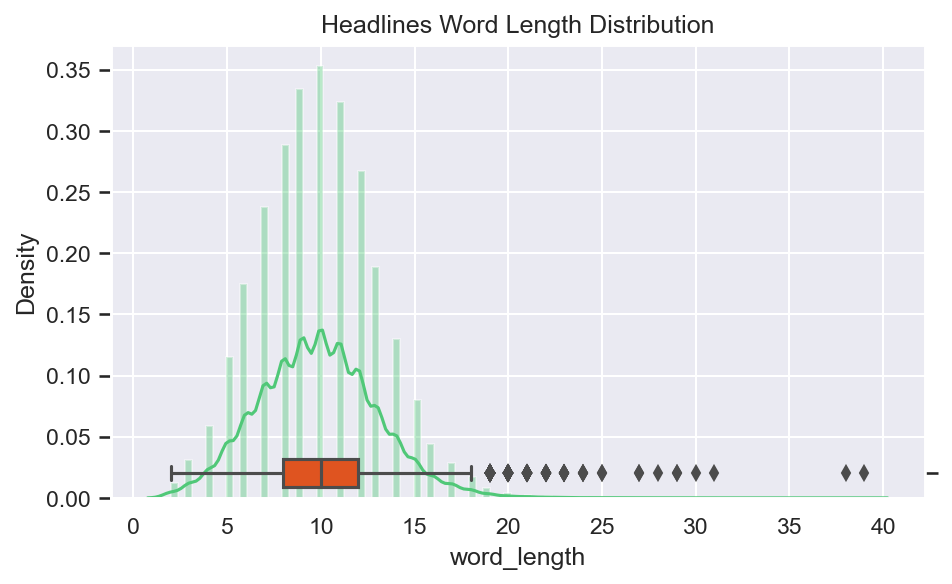

In [12]:
# plotting sign counts distribution
sns.set()
plt.figure(figsize=(7, 4), dpi=150)
ax = sns.distplot(dataset.word_length, bins=100, kde=True, color='#50C878')
ax_ = ax.twinx()
sns.boxplot(dataset.word_length, color='#FF4500')
ax_.set(ylim=(-.7, 12))
plt.title('Headlines Word Length Distribution')
plt.show()

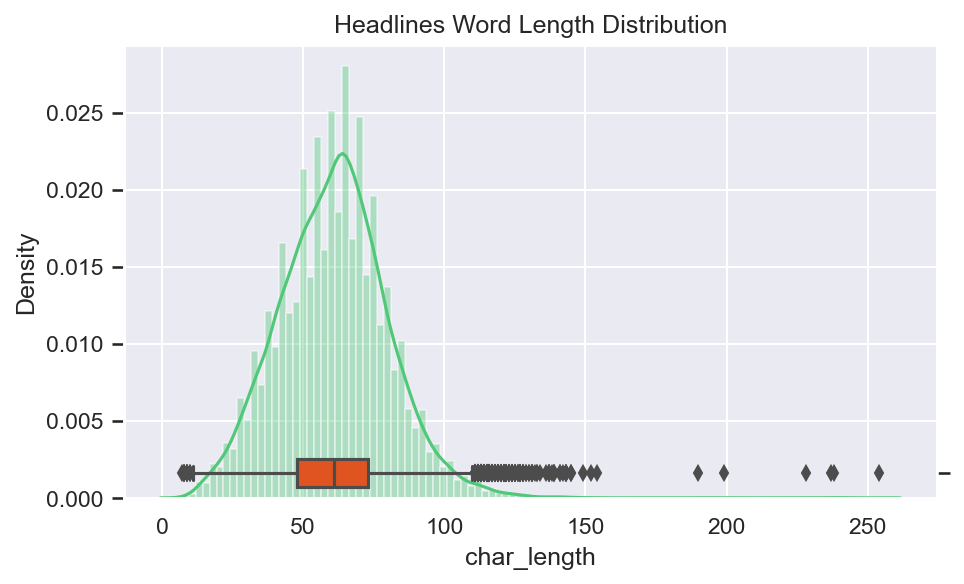

In [13]:
# plotting sign counts distribution
sns.set()
plt.figure(figsize=(7, 4), dpi=150)
ax = sns.distplot(dataset.char_length, bins=100, kde=True, color='#50C878')
ax_ = ax.twinx()
sns.boxplot(dataset.char_length, color='#FF4500')
ax_.set(ylim=(-.7, 12))
plt.title('Headlines Word Length Distribution')
plt.show()

In [14]:
dataset.describe()

,is_sarcastic,char_length,word_length
count,26709.000000,26709.000000,26709.000000
mean,0.438953,60.910592,9.845820
std,0.496269,19.184470,3.168955
min,0.000000,7.000000,2.000000
25%,0.000000,48.000000,8.000000
50%,0.000000,61.000000,10.000000
75%,1.000000,73.000000,12.000000
max,1.000000,254.000000,39.000000


<h5><ul>
<span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">
    <li>Most headline texts have between 2 and 12 with median at 10 (61 characters) and mean at 9.8 with relatively few outliers ranging till 39 words (254 characters)<br>
 </span></ul></h5>

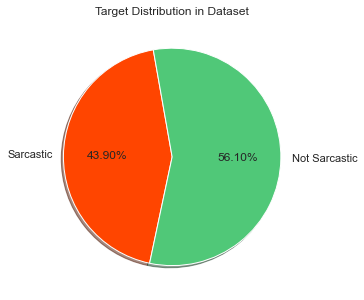

In [15]:
# plotting the sentiment distribution in training set

sarcastic = len(dataset[dataset['is_sarcastic'] == 1])
not_sarcastic = len(dataset[dataset['is_sarcastic'] == 0])

plt.pie(x=[sarcastic, not_sarcastic],
        explode=(0, 0),
        labels=['Sarcastic', 'Not Sarcastic'],
        autopct='%1.2f%%',
        shadow=True,
        startangle=100,
        colors=['#FF4500', '#50C878'])

fig = plt.gcf()
fig.set_size_inches(5, 5)
plt.title('Target Distribution in Dataset')
plt.show()

<h5><ul>
<span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">
    <li>The target class distribution is relatively balanced and we do not need to perform any further imputation for modelling. 56.1% of the headlines are not sarcastic (huffington post), wheras 43.9% of the headlines are sarcastic (the onion)
 </span></ul></h5>

In [16]:
# top 50 most frequent words in text
top_N = 50

words = (dataset.headline.str.cat(sep=' ').split())
rslt = pd.DataFrame(Counter(words).most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')

In [17]:
rslt[:50].transpose()

Word,to,of,the,in,for,a,on,and,with,is,...,have,why,one,area,donald,over,says,can,woman,u.s.
Frequency,8206,5593,5177,4170,3297,2961,2371,1885,1797,1666,...,489,489,487,484,468,466,450,438,420,410


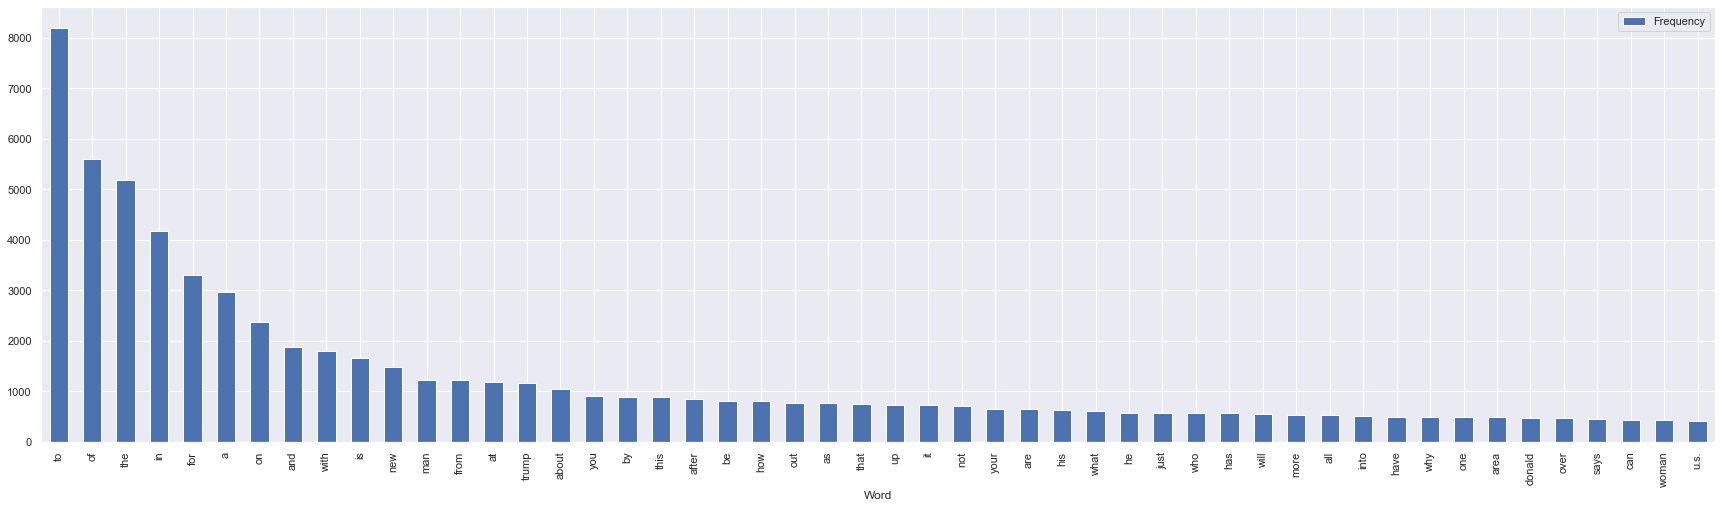

In [18]:
rslt.plot.bar(rot=0, figsize=(30,8), width=0.55)
plt.xticks(rotation=90)
plt.show()

In [19]:
pprint(rslt.index.tolist(), compact=True)

['to', 'of', 'the', 'in', 'for', 'a', 'on', 'and', 'with', 'is', 'new', 'man',
 'from', 'at', 'trump', 'about', 'you', 'by', 'this', 'after', 'be', 'how',
 'out', 'as', 'that', 'up', 'it', 'not', 'your', 'are', 'his', 'what', 'he',
 'just', 'who', 'has', 'will', 'more', 'all', 'into', 'have', 'why', 'one',
 'area', 'donald', 'over', 'says', 'can', 'woman', 'u.s.']


<h5><ul>
<span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">
    <li>Many stopwords are occuring most frequently in the dataset. We might need to use stopword removal in our pre-processing if it improves the model performance.
 </span></ul></h5>

In [20]:
dataset

,headline,is_sarcastic,char_length,word_length
0,former versace store clerk sues over secret 'b...,0,78,12
1,the 'roseanne' revival catches up to our thorn...,0,84,14
2,mom starting to fear son's web series closest ...,1,79,14
3,"boehner just wants wife to listen, not come up...",1,84,13
4,j.k. rowling wishes snape happy birthday in th...,0,64,11
...,...,...,...,...
26704,american politics in moral free-fall,0,36,5
26705,america's best 20 hikes,0,23,4
26706,reparations and obama,0,21,3
26707,israeli ban targeting boycott supporters raise...,0,60,8


In [21]:
pos_string = ""
pos = dataset.loc[dataset.is_sarcastic == 1, 'headline']
for headline in pos:
    pos_string += headline
    pos_string += " "

neg_string = ""
neg = dataset.loc[dataset.is_sarcastic == 0, 'headline']
for headline in neg:
    neg_string += headline
    neg_string += " "

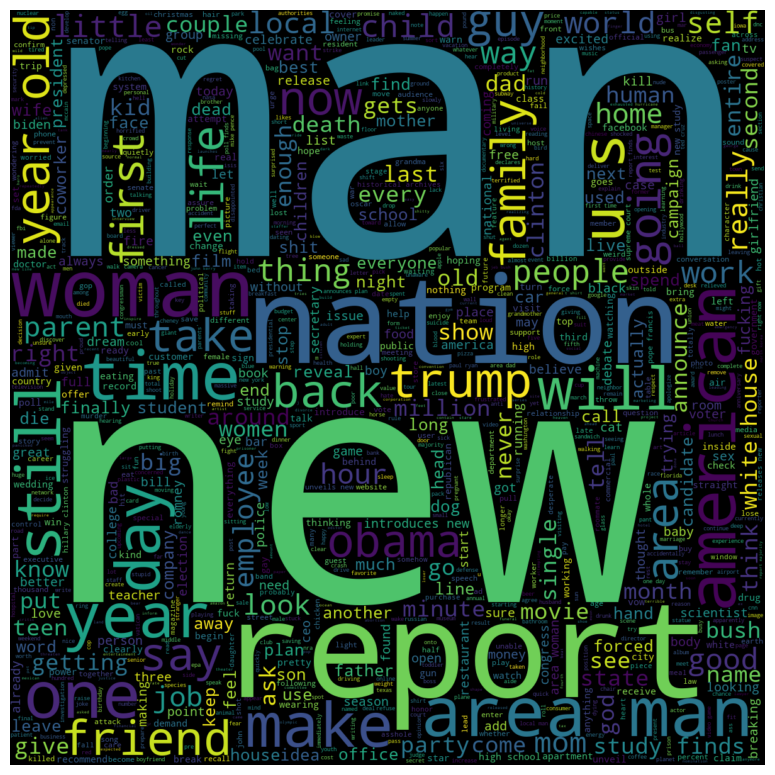

In [22]:
# Sarcastic headlines wordcloud
plt.figure(figsize=(10,10), dpi=100)
WC = WordCloud(width=1200, height=1200, max_words=1000, min_font_size=5)
positive_words = WC.generate(pos_string)
plt.imshow(positive_words,interpolation='bilinear')
plt.axis("off")
plt.show()

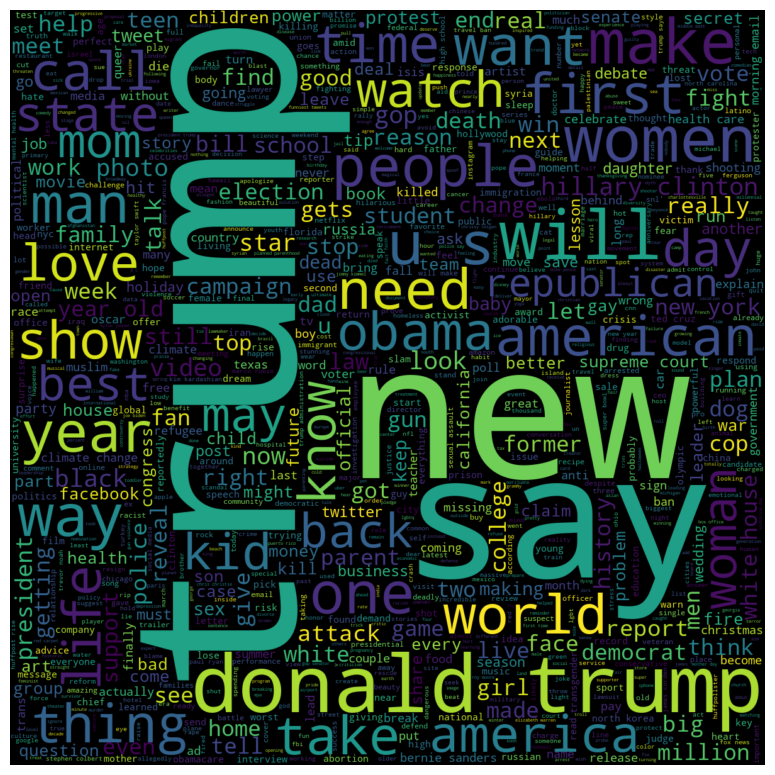

In [23]:
# Non-Sarcastic headlines wordcloud
plt.figure(figsize=(10,10), dpi=100)
WC = WordCloud(width=1200, height=1200, max_words=1000, min_font_size=5)
negative_words = WC.generate(neg_string)
plt.imshow(negative_words,interpolation='bilinear')
plt.axis("off")
plt.show()

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Pre-Processing</span></strong></li>
</ul></h3>

In [24]:
# !pip install spacy
# !python -m spacy downlaod en_core_web_sm

import nltk
import spacy

nltk.download('punkt')
nltk.download('stopwords')
# Initialize spacy 'en_core_web_sm' model
nlp = spacy.load('en_core_web_sm', disable=['parser'])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\surya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\surya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
# utility functions for text preprocesing
import re
import string
import unicodedata
import contractions
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.snowball import SnowballStemmer

CUSTOM = True

stemmer = SnowballStemmer('english')
if CUSTOM:
    stop_words = set(nltk.corpus.stopwords.words('english'))
    # custom stopwords added from the most frequent words which are generic 
    # and might not relate to the sentiment of the review
    stop_words.update(['urllink'])
else:
    stop_words = set(nltk.corpus.stopwords.words('english'))

def replace_accented_chars(review_text):
    '''normalizes and replaces accented characters'''
    unaccented_text = unicodedata.normalize('NFKD', review_text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return unaccented_text



def strip_html_tags(review_text):
    '''strips html tags like <h4> ..etc'''
    soup = BeautifulSoup(review_text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text


def expand_contractions(review_text):
    review_text = contractions.fix(review_text)
    return review_text


def remove_special_characters(review_text):
    '''
    Remove special characters but preserve digits and excalamation marks
    as they indicate emotionally charged review '''
    review_text = re.sub(r"[^A-Za-z0-9!?\'\`]", " ", review_text)
    return review_text


def strip_stops(text, is_lower_case=False, stop_words=stop_words):
    '''strip stopwrds'''
    tokens = text.split()
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stop_words]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text


def snowball_stem(text, stemmer=stemmer):
    '''stemming using snowball stemmer'''
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    review_text = " ".join(stemmed_words)
    return review_text


def tokenize(text):
    '''tokenize using spaCy'''
    doc = nlp(text)
    return " ".join([t.text for t in doc])


def lemmatize(text):
    '''lemmatize using spaCy'''
    doc = nlp(text)
    return " ".join([t.lemma_ for t in doc])

In [26]:
def preprocess_text(text: str,
                    lower=True,
                    strip_stopwords=False) -> str:
    text = replace_accented_chars(text)
    text = strip_html_tags(text)
    text = expand_contractions(text)
    text = remove_special_characters(text)
    if lower:
        text = text.lower()
    if strip_stopwords:
        text = strip_stops(text)
    text = lemmatize(text)
    return str(text.strip())


sentence = "<p>How're you Doing? 😊</p>"
cleaned = preprocess_text(sentence)
cleaned

'how be you do ?'

In [27]:
def preprocess(row):
    text = row.headline
    if isinstance(text, str):
        text = preprocess_text(text)
    else:
        text = np.nan
    row['cleaned_headline'] = text

    return row

In [28]:
dataset = dataset.progress_apply(preprocess, axis=1)

100%|███████████████████████████████████████████████████████████████████████████| 26709/26709 [01:47<00:00, 249.28it/s]


In [29]:
dataset.isna().sum()

headline            0
is_sarcastic        0
char_length         0
word_length         0
cleaned_headline    0
dtype: int64

In [30]:
dataset.sample(7)

,headline,is_sarcastic,char_length,word_length,cleaned_headline
16866,national filmstrip board calls for quiet,1,40,6,national filmstrip board call for quiet
16101,10 things no one told me before my c-section,0,44,9,10 thing no one tell I before my c section
14565,why 'it's the thought that counts' is an outda...,0,56,10,why ' it be the thought that count ' be an out...
21621,grandfather clock does loop-the-loop with pend...,1,70,10,grandfather clock do loop the loop with pendul...
26339,series of grave errors results in jeff and kim...,1,64,11,series of grave error result in jeff and kim '...
523,whoops! selfie snapper smashes sculpture days ...,0,65,9,whoop ! selfie snapper smashes sculpture day a...
26163,brutal gang rape gives screenplay more 'punch',1,46,7,brutal gang rape give screenplay more ' punch '


<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Tokenize and pad sequences</span></strong></li>
</ul></h3>

In [31]:
# define params
NUM_WORDS = 20000
MAX_LEN = dataset['word_length'].max()
EMBEDDING_DIM = 200

In [32]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


tokenizer = Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(dataset['cleaned_headline'])
X = tokenizer.texts_to_sequences(dataset['cleaned_headline'])

# pad sequences to cut longer texts to a uniform length and pad the sentences that are shorter than that with <PAD> token

# using just 20 words from each headline will severely limit the information that is 
# available to the model and affect performance although the training will be faster
X = pad_sequences(X,
                  padding='post',
                  truncating='post',
                  maxlen=MAX_LEN)
y = np.asarray(dataset['is_sarcastic'])

print(f'X:  {X.shape}\ny:  {y.shape}')

X:  (26709, 39)
y:  (26709,)


In [33]:
pprint(X[0], compact=True)

array([  369, 11351,   613,  2724,   960,    57,   325,     2,   115,
        1875,     2,     8,  2037,  3495,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0])


In [34]:
y[0]

0

In [35]:
WORD_TO_INDEX = tokenizer.word_index
# pprint(WORD_TO_INDEX, compact=True)
pprint(list(WORD_TO_INDEX.keys())[:100], compact=True)

['to', "'", 'of', 'the', 'be', 'in', "'s", 'for', 'a', 'on', 'and', 'not',
 'with', 'trump', 'you', 'new', 'man', 'have', 'from', 'at', 'it', 'about',
 'do', 'he', 'get', 'this', 'by', 'woman', 'up', 'after', 'out', 'that', 'how',
 'year', 'will', 'as', 'make', 'say', 'what', 'can', 'your', 'i', 'his', 'who',
 'report', 'we', 'just', 'all', 'one', 'day', 'more', 'go', 'into', 'why',
 'time', 'area', 'over', 'they', 'take', 'donald', 'find', 'old', 's', 'good',
 'like', 'life', 'first', 'obama', 'no', 'people', 'way', 'she', 'world', 'off',
 'show', 'an', 'nation', 'house', 'back', 'thing', 'now', 'look', 'call',
 'want', 'give', 'clinton', 'white', 'child', 'know', 'still', 'family', 'than',
 'would', 'my', 'down', 'watch', 'come', 'think', 'could', 'work']


In [36]:
VOCAB_SIZE = len(WORD_TO_INDEX) + 1
VOCAB_SIZE

19971

In [37]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
def retrieve_headline_feat(x, mapping=WORD_TO_INDEX) -> str:
    # increment 3 
    mapping = {k:(v + 3) for k, v in mapping.items()}
    mapping['<PAD>'] = 0
    mapping['<START>'] = 1
    mapping['<UNK>'] = 2
    inv_mapping = {v: k for k, v in mapping.items()}
    return str(" ".join(inv_mapping.get(i, '<NA>') for i in x))

retrieve_headline_feat(X[0])

'celebrate herpetologist internet stadium defense why away <UNK> tell commit <UNK> be actress consecutive <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>'

In [38]:
y[0]

0

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Split into Train-Test</span></strong></li>
</ul></h3>

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
print(f"Train dataset shape: {X_train.shape}, \nTest dataset shape: {X_test.shape}")

Train dataset shape: (21367, 39), 
Test dataset shape: (5342, 39)


<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">GloVe Embeddings</span></strong></li>
</ul></h3>

In [40]:
def get_embedding_matrix(embedding_dim=EMBEDDING_DIM):
    embeddings = defaultdict()
    if embedding_dim == 200:
        file_path = f'./data/glove.6B.{embedding_dim}d.txt'
    elif embedding_dim == 300:
        file_path = f'./data/glove.840B.{embedding_dim}d.txt'
    for l in open(file_path, encoding='utf-8'):
        word = l.split(" ")[0]
        embeddings[word] = np.asarray(l.split(" ")[1:], dtype='float32')

    embeddings = dict(embeddings)

    # create a weight matrix for words in training docs
    embedding_matrix = np.zeros((NUM_WORDS, embedding_dim))

    for word, idx in WORD_TO_INDEX.items():
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [41]:
# use pre-trained glove embedding matrix to initialize weights in our model
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(20000, 200)

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Train Sarcasm Detectors</span></strong></li>
</ul></h3>

<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Bi-Directional LSTM</span></strong></li>
</ul></h4>

In [42]:
# !pip install livelossplot
from tensorflow.python.keras.models import Sequential
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm, unit_norm
from tensorflow.python.keras.callbacks import LambdaCallback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import (Flatten,
                                     Dense,
                                     Activation,
                                     BatchNormalization,
                                     Dropout,
                                     Embedding,
                                     LSTM,
                                     MaxPooling1D,
                                     Bidirectional,
                                     GlobalMaxPool1D)

In [43]:
VOCAB_SIZE, MAX_LEN, EMBEDDING_DIM, NUM_WORDS

(19971, 39, 200, 20000)

In [44]:
# define model

model1 = Sequential([
    Embedding(NUM_WORDS, EMBEDDING_DIM, embeddings_initializer=Constant(embedding_matrix),
              input_length=MAX_LEN, trainable=False),
    Bidirectional(LSTM(256, return_sequences=True)),
    GlobalMaxPool1D(),
    Dropout(0.5),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model1.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [45]:
# Define Callbacks and a few helper functions

# simplify the training log
simple_log = LambdaCallback(
    on_epoch_end = lambda e, l: print(f" ~| Epoch: {e+1} | Validation Loss: {l['val_loss']:.5f}", end =" >|> \n" ))

# early stopping
early_stop = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=7,
                              verbose=0, 
                              restore_best_weights=True)

# learning rate reduction
lr_reduce_on_plateau = ReduceLROnPlateau(monitor='val_loss', 
                                         patience=3, 
                                         verbose=1, 
                                         factor=0.4,
                                         min_lr=0.00001)

def plot_learning_curve(hist):
    sns.set()
    plt.figure(figsize=(5,5))
    train = hist.history['loss']
    val = hist.history['val_loss']
    epochs_run = range(1,len(train) + 1)
    sns.lineplot(epochs_run, train, marker = 'o', color = 'coral', label = 'Training Loss')
    sns.lineplot(epochs_run, val,  marker = '>', color = 'green', label = 'Validation Loss')
    plt.title("Loss vs. Epochs", fontsize = 20)
    plt.legend()
    plt.show()

In [46]:
import gc
gc.collect()

17

In [47]:
EPOCHS = 200
if tensorflow.config.list_physical_devices('GPU'):
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h1 = model1.fit(
            X_train, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop, lr_reduce_on_plateau],
            verbose = False)
else:
    print("Training on CPU:")
    h1 = model1.fit(
            X_train, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop, lr_reduce_on_plateau],
            verbose = False)

print("\nTraining Done.")

Training on CPU:
 ~| Epoch: 1 | Validation Loss: 0.41577 >|> 
 ~| Epoch: 2 | Validation Loss: 0.34888 >|> 
 ~| Epoch: 3 | Validation Loss: 0.32853 >|> 
 ~| Epoch: 4 | Validation Loss: 0.34711 >|> 
 ~| Epoch: 5 | Validation Loss: 0.36703 >|> 
 ~| Epoch: 6 | Validation Loss: 0.32666 >|> 
 ~| Epoch: 7 | Validation Loss: 0.40675 >|> 
 ~| Epoch: 8 | Validation Loss: 0.38269 >|> 
 ~| Epoch: 9 | Validation Loss: 0.47575 >|> 

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
 ~| Epoch: 10 | Validation Loss: 0.54211 >|> 
 ~| Epoch: 11 | Validation Loss: 0.63211 >|> 
 ~| Epoch: 12 | Validation Loss: 0.66150 >|> 

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.00016000000759959222.
 ~| Epoch: 13 | Validation Loss: 0.73074 >|> 

Training Done.


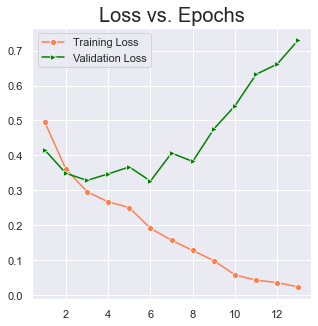

In [48]:
plot_learning_curve(h1)

In [49]:
loss, acc = model1.evaluate(X_test, y_test)
print("Testing Accuracy: ", acc*100)

167/167 [==============================] - 6s 33ms/step - loss: 0.3156 - accuracy: 0.8712
Testing Accuracy:  87.12092638015747


300d

In [50]:
# 300d GloVe
embeding_dim = 300
embedding_matrix_2 = get_embedding_matrix(embedding_dim=embeding_dim)
embedding_matrix_2.shape

(20000, 300)

In [51]:
# define model

model2 = Sequential([
    Embedding(NUM_WORDS, embeding_dim, embeddings_initializer=Constant(embedding_matrix_2),
              input_length=MAX_LEN, trainable=False),
    Bidirectional(LSTM(256, return_sequences=True)),
    GlobalMaxPool1D(),
    Dropout(0.5),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model2.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [52]:
EPOCHS = 200
if tensorflow.config.list_physical_devices('GPU'):
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h2 = model2.fit(
            X_train, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop, lr_reduce_on_plateau],
            verbose = False)
else:
    print("Training on CPU:")
    h2 = model2.fit(
            X_train, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop, lr_reduce_on_plateau],
            verbose = False)

print("\nTraining Done.")

Training on CPU:
 ~| Epoch: 1 | Validation Loss: 0.36794 >|> 
 ~| Epoch: 2 | Validation Loss: 0.33578 >|> 
 ~| Epoch: 3 | Validation Loss: 0.31297 >|> 
 ~| Epoch: 4 | Validation Loss: 0.31551 >|> 
 ~| Epoch: 5 | Validation Loss: 0.30557 >|> 
 ~| Epoch: 6 | Validation Loss: 0.38946 >|> 
 ~| Epoch: 7 | Validation Loss: 0.36479 >|> 
 ~| Epoch: 8 | Validation Loss: 0.46373 >|> 

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
 ~| Epoch: 9 | Validation Loss: 0.56638 >|> 
 ~| Epoch: 10 | Validation Loss: 0.65730 >|> 
 ~| Epoch: 11 | Validation Loss: 0.66248 >|> 

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.00016000000759959222.
 ~| Epoch: 12 | Validation Loss: 0.76925 >|> 

Training Done.


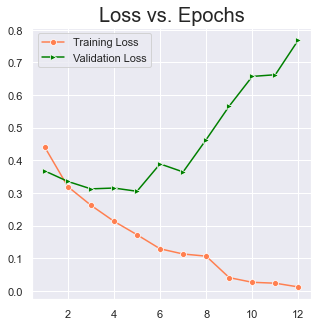

In [53]:
plot_learning_curve(h2)

In [54]:
loss, acc = model2.evaluate(X_test, y_test)
print("Testing Accuracy: ", acc*100)

167/167 [==============================] - 8s 45ms/step - loss: 0.2807 - accuracy: 0.8817
Testing Accuracy:  88.16922307014465


In [55]:
from sklearn.metrics import classification_report

y_pred = (model2.predict(X_test) > 0.5).astype('int32')
print(f'Classification Report:\n{classification_report(y_pred, y_test)}')

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      3067
           1       0.86      0.87      0.86      2275

    accuracy                           0.88      5342
   macro avg       0.88      0.88      0.88      5342
weighted avg       0.88      0.88      0.88      5342



<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Metrics: </span></strong></li>
</ul></h3>

<table style="width:100%">
  <tr>
    <th>Model</th>
    <th>Test Accuracy</th>
  </tr>
  <tr>
    <td>BiDirectional LSTM + Pre-trained 200d GloVe vectors</td>
    <td>87.12</td>
  </tr>
<tr>
    <td>BiDirectional LSTM + Pre-trained 300d GloVe vectors</td>
    <td>88.17</td>
  </tr>
</table>

<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">So, the best model acheived an accuracy of 88.17%. We, choose the test accuracy as the final metric to benchamrk models as the classes are balanced (no heavy imbalance to skew accuracy metrics) and we have a good distribution in both train and test datasets. Also, we're interested in performance on both the classes. To improve the accurac further, we can use BERT or other Transformer-based classifiers which use Attention Mechanism and are generally much better at text classification tasks.</span></strong></li>
</ul></h4>

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Use the designed model to print the prediction on any one sample</span></strong></li>
</ul></h3>

In [56]:
def predict_sarcasm(text: str, actual_label: int,
                    preprocess_text=preprocess_text,
                    tokenizer=tokenizer,
                    classifier=model2):
    '''helper function to predict sarcasm given text'''
    label_to_val = {1: 'Sarcastic', 0: 'Not Sarcastic'}
    text = preprocess_text(text)
    x = tokenizer.texts_to_sequences([text])
    x = pad_sequences(x,
                      padding='post',
                      truncating='post',
                      maxlen=MAX_LEN)
    pred = (classifier.predict(x) > 0.5).astype('int32')[0][0]
    print(f'Predicted: {label_to_val.get(pred, "ERR")}')
    print(f'Actual:    {label_to_val.get(actual_label, "ERR")}')

In [57]:
# select a few random headline from dataset
for _ in range(5):
    idx = random.choice(range(len(dataset)))
    random_headline = dataset.headline.iloc[idx]
    actual_sentiment = dataset.is_sarcastic.iloc[idx]
    # print headline
    pprint(random_headline, compact=True)
    
    # prediction
    predict_sarcasm(random_headline, actual_sentiment)
    print("")

("nation's grandfathers to receive annual shipment of $2 bills from u.s. "
 'treasury')
Predicted: Sarcastic
Actual:    Sarcastic

'drake throws money and angrily storms into club'
Predicted: Not Sarcastic
Actual:    Not Sarcastic

'politician spots young female aide, and so it begins'
Predicted: Sarcastic
Actual:    Sarcastic

'high school decides against suspending football player for peaceful protest'
Predicted: Not Sarcastic
Actual:    Not Sarcastic

('dog dies on united flight after passenger forced to put carrier in overhead '
 'bin')
Predicted: Not Sarcastic
Actual:    Not Sarcastic



In [58]:
# random movie headline taken from imdb as an out sample test
# Satirical UK site (NewsThump)
# https://newsthump.com/2021/08/13/millions-of-homes-to-be-demolished-to-encourage-home-workers-back-into-office/
oos_headline = 'Millions of homes to be demolished to encourage home workers back into office'

predict_sarcasm(oos_headline, 1)

Predicted: Sarcastic
Actual:    Sarcastic
